# Simulation Environment

We will place an agent inside a simple world that has some number of fruit trees place within it at various fixed locations. The fruit of these trees may be edible or poisonous, and the agent must find edible fruit to survive. The trees have only a finite number of fruit, so that an agent cannot afford to just stay near one tree to survive. It must move around and explore. 

This world is static; only the agent moves, and the trees stay put. This is aligned with our goal of map-building. If you plan to traverse highways to get from one place to another, your plan does not depend on the cars that are on the road. You respond to the cars on the road once you are there with them on the road.

We will build up this world first by modeling trees, then contents of the world, and then finally the agent itself, with defined actions and sensors.

The purpose of this page is to discuss the design goals and parameters and to demonstrate how the simulation supports those goals. The contents of this page are for the most part implemented in `tree_world.simulation`.

## Defining Trees

A tree must have a location in the world, and it may have fruit. The fruit must be limited to keep the agent moving, so we provide a `max_fruit` value for this limit. That means we have to track the current number of `fruit`. We will let the tree regrow `max_fruit` after a fixed number of steps, given by `regrow_every` below. The tree itself will be poisonous or not (`is_poisonous`), so that the agent can predict whether or not edible fruit might be found on the tree.

Furthermore, the agent will be able to sense the tree, for which purpose we assign the tree an `embedding` tensor. To get this embedding tensor, we `name` the tree by type, e.g. "mango", "apple", "pear", _etc_, and we further give the tree a unique `tree_id ` like "Bob" or "Sue".

At each step of world time, the tree will count up until it is time to regrow all fruit; once this threshold is crossed, the fruit regrows and the `regrow_count` is reset to zero.

Further, at any time step, the agent may `harvest_fruit()`, which reduces the count of `fruit` on the tree by one. The execution of this function is left to the agent. If there is no fruit on the tree, the agent will get a response of `0`, but otherwise `1` will be returned.

In [1]:
import torch

class Tree:
    def __init__(self, tree_id: str, name: str, embedding: torch.Tensor, location: torch.Tensor, 
                       max_fruit: int, is_poisonous: bool, regrow_every: int):
        self.tree_id = tree_id
        self.name = name
        self.embedding = embedding
        self.location = location
        self.max_fruit = max_fruit
        self.fruit = max_fruit
        self.is_poisonous = is_poisonous
        self.regrow_every = regrow_every
        self.regrow_count = 0

    def step(self):
        self.regrow_count = self.regrow_count + 1
        if self.regrow_count >= self.regrow_every:
            self.regrow_fruit()
            self.regrow_count = 0

    def regrow_fruit(self):
        self.fruit = self.max_fruit

    def harvest_fruit(self):
        harvested_fruit = min(self.fruit, 1)
        self.fruit = max(self.fruit - 1, 0)
        return harvested_fruit

tree = Tree(tree_id="Bob", name="apple", embedding=torch.randn(10), location=torch.randn(2), 
            max_fruit=10, is_poisonous=False, regrow_every=100)

tree.step()
tree.harvest_fruit()



1

## Representing Trees with Embeddings

The purpose of the sensors is to give the agent information it can use to satisfy its hunger. Thus the sensor must return a value that is sufficient to distinguish trees with edible fruit from trees with poisonous fruit. To do this, we use text embeddings, which should contain sufficient information to map tree names to the edibility of their fruit ("banana" vs. "nightshade"). In a more complex system, these sensory embeddings would be learned to predict both drive satisfaction and future sensory states.

For this simple example the tree has a type (`name`) and an id (`tree_id`). We use both to generate the tree embedding. The type lets us identify whether or not the tree can satisfy hunger, and the id gives each tree a unique embedding. As a simple first approach, we just sum the two embeddings.

In [2]:
import sentence_transformers

hf_models = {}
def embed_text_sentence_transformers(text, method="BAAI/bge-large-en-v1.5"):
    global hf_models
    if method not in hf_models:
        hf_models[method] = sentence_transformers.SentenceTransformer(method)

    model = hf_models[method]

    if isinstance(text, list):
        if len(text) == 0:
            return None
        # note that we clone the output to avoid messages about inference tensors not requiring grad
        return model.encode(text, convert_to_tensor=True, normalize_embeddings=True).clone()
    else:
        return model.encode([text], convert_to_tensor=True, normalize_embeddings=True)[0].clone()


embeddings = embed_text_sentence_transformers([tree.name, tree.tree_id])
name_embedding = embeddings[0]
tree_id_embedding = embeddings[1]

tree.embedding = name_embedding + tree_id_embedding

print("Our tree embedding has shape ", tree.embedding.shape)
print(f"Our tree embedding has norm {torch.norm(tree.embedding).item()}")
print("Here are a few of its values: ", tree.embedding[:10].cpu().numpy().tolist())




Our tree embedding has shape  torch.Size([1024])
Our tree embedding has norm 1.8172615766525269
Here are a few of its values:  [0.006948765367269516, -0.05999569222331047, 0.0028325840830802917, 0.0032070516608655453, -0.05659116804599762, -0.004542641807347536, 0.1010943353176117, 0.0244026780128479, 0.07085493206977844, 0.0802859514951706]


We will also add to our embeddings the ability to sense how many fruit are on the tree, if the agent is close enough. For this, we have a configuration `can_see_fruit_distance` that determines what "close enough" means. Then we add in more text embeddings reflecting possible fruit values and provide a method to the `Tree` class that computes these embeddings. 

In [3]:
class Tree:
    def __init__(self, tree_id: str, name: str, embedding: torch.Tensor, location: torch.Tensor, 
                       max_fruit: int, is_poisonous: bool, regrow_every: int, can_see_fruit_distance: float,
                       sensory_embedding_model: str='BAAI/bge-large-en-v1.5'):
        self.tree_id = tree_id
        self.name = name
        self.embedding = embedding
        self.location = location
        self.max_fruit = max_fruit
        self.fruit = max_fruit
        self.is_poisonous = is_poisonous
        self.regrow_every = regrow_every
        self.regrow_count = 0
        self.can_see_fruit_distance = can_see_fruit_distance

        self.num_fruit_embeddings = self.setup_fruit_embeddings(sensory_embedding_model)

    def step(self):
        self.regrow_count = self.regrow_count + 1
        if self.regrow_count >= self.regrow_every:
            self.regrow_fruit()
            self.regrow_count = 0

    def regrow_fruit(self):
        self.fruit = self.max_fruit

    def harvest_fruit(self):
        harvested_fruit = min(self.fruit, 1)
        self.fruit = max(self.fruit - 1, 0)
        return harvested_fruit
    
    def setup_fruit_embeddings(self, sensory_embedding_model: str):
        num_fruit_strs = ["no fruit", "one fruit", "two fruit", "several fruit", "many fruit"]
        fruit_embeddings = embed_text_sentence_transformers(num_fruit_strs, sensory_embedding_model)
        return {num_fruit_str: fruit_embedding for num_fruit_str, fruit_embedding in zip(num_fruit_strs, fruit_embeddings)}

    def get_embedding(self, distance: float):
        if distance is None:
            return torch.zeros(self.sensory_embedding_dim)
        elif distance > self.can_see_fruit_distance:
            return self.embedding
        else: 
            if self.fruit == 0:
                num_fruit_str = "no fruit"
            elif self.fruit == 1:
                num_fruit_str = "one fruit"
            elif self.fruit == 2:
                num_fruit_str = "two fruit"
            elif 3 <= self.fruit <= 5:
                num_fruit_str = "several fruit"
            else:
                num_fruit_str = "many fruit"

            fruit_embedding = self.num_fruit_embeddings[num_fruit_str]
            return self.embedding + fruit_embedding

## The Agent and its Sensors

Our agent is fairly simple. Its action will be undertaken by a `model` based on the output of a `sensor`. The agent has a `max_health` that is cannot exceed, no matter how much it eats. It lives in a 2-D world (`dim`), and has a `location` at all times that represents where the agent is in our simulation.

When the agent moves, its health goes down by `move_cost`. But if it stays still, there is a `rest_cost`. Thus the agent will die without food, whether it moves or is still. 

In order to eat, an agent must get near a tree. In the real world, an agent would then have to reach out and pick the fruit, then put it into its mouth and chew. In our simplified world, the agent eats whenever it gets close to a tree with fruit (<`eat_distance`). When it eats fruit, its health is restored by `fruit_health_increase`. By staying at a tree with multiple fruit, the agent can eat on successive turns.

We track the amount of fruit, poisonous and edible, that the agent eats during a simulation (`fruit_eaten` and `poisonous_fruit_eaten`). Between simulations, we `reset()` the agent to its max health and no fruit eaten. 

The agent has a `heading` that represents the direction it is facing, and is hence a unit vector. Depending on the sensor, this may or may not be taken into account when sensing. For our basic design, the heading is initially unused.

At each time step, the agent senses the environment (`sensor.sense()`), eats fruit if it is near a tree, and computes its next action (`model.get_action()`), which consists of a movement in space (`position_delta`) and a new heading (`new_heading`). The agent may return `position_delta=None` or a near zero value in order to rest, or else the agent will move in the indicated direction, updating its location. In either case, the agent's health goes down, incurring the rest or movement cost as appropriate.


In [4]:
class Agent:
    def __init__(self, model: 'AgentModel', sensor: 'Sensor', max_health: int, dim: int=2, move_cost: int=2, rest_cost: int=1,
                 eat_distance: float=1.0, fruit_health_increase: float=10.0):
        self.location = torch.zeros(dim)
        self.heading = torch.randn(dim)
        self.heading = self.heading / torch.norm(self.heading)
        self.sensor = sensor
        self.model = model
        self.dim = dim
        self.max_health = max_health
        self.health = max_health

        self.move_cost = move_cost
        self.rest_cost = rest_cost

        self.max_distance = 100.0
        self.eat_distance = eat_distance
        self.fruit_health_increase = fruit_health_increase
        self.fruit_eaten = 0
        self.poisonous_fruit_eaten = 0

        self.total_movement = 0.0

    def reset(self):
        self.health = self.max_health
        self.fruit_eaten = 0
        self.poisonous_fruit_eaten = 0
        self.model.reset()
        self.total_movement = 0.0

    def step(self, world: 'TreeWorld'):
        distance, embedding, tree = self.sensor.sense(world, self.location, self.heading)

        if distance is not None and distance < self.eat_distance:
            # print(f"Eating fruit from tree {tree.name} with fruit amount {num_fruit}")
            self.fruit_eaten += 1
            if tree.is_poisonous:
                self.poisonous_fruit_eaten += 1

            self.eat_fruit(1, tree.is_poisonous)
            tree.harvest_fruit()
        
        position_delta, self.heading = self.model.get_action(distance, embedding, self.heading, self.health / self.max_health,
                                                             self.location, tree.location if tree is not None else None)

        if position_delta is None or torch.norm(position_delta) < 1e-8:
            self.rest()
        else:
            self.move(position_delta)

    def move(self, direction: torch.Tensor):
        self.location = self.location + direction
        self.health = self.health - self.move_cost
        self.total_movement = self.total_movement + torch.norm(direction)

    def rest(self):
        self.health = self.health - self.rest_cost

    def eat_fruit(self, fruit: int, is_poisonous: bool):
        if is_poisonous:
            self.health = self.health - fruit * self.fruit_health_increase
        else:
            self.health = self.health + fruit * self.fruit_health_increase

        if self.health > self.max_health:
            self.health = self.max_health

The agent's sensor is responsible to return three things:
- The distance to the nearest tree, or `None` if no tree is close
- The sensor value for the current agent location and configuration
- The closest tree object to the agent, or `None` if no tree is close

To do this, it will need access to all the information about the world as well as the agent's location and heading.

In [5]:
class Sensor:
    def sense(self, world: 'TreeWorld', position: torch.Tensor, heading: torch.Tensor):
        raise NotImplementedError("Subclasses must implement this method")

Now we'll discuss two versions of this sensor.

## A Simple Chemical Sensor

For our simple navigator agent, we can treat sensory data like smell: our trees are distributed through the environment, and they diffuse scents indicating their identity. At a given point, the sense of smell detects a combination of data from nearby trees.

The 'scent' $z$ of a tree should be detected proprotionately to the distance from a tree. I model the decay of the scent via a diffusion process. The model for diffusion (the physical process, not the algorithm) is based on the heat equation $u(x,t)$ is $$\frac{1}{2} \frac{\partial u}{\partial t} = \sum_i \frac{\partial^2 u}{\partial x_i^2} = \Delta u,$$ where $\Delta u$ is called the _Laplacian_. The heat equation is solved by
$$u(x, t) = \frac{c}{\sqrt{t^d}} \exp\left(-\frac{1}{2t} \|x - \mu\|^2\right),$$ 
where $d$ is the dimension of the space, $c$ is any constant, and $\mu$ is the intial point where diffusion starts.

Here $u(x,t)$ is the diffused quantity. For clarity, $x$ is the location of the sensor, and $\mu$ is the location of the source tree. At $u(x, 0) = c$, this is a point mass at $\mu$. Our interest is to choose a virtual time $t$ such that controls the spread of the tree's sense such that (a) trees can be sensed from a distance, and (b) trees are still distinct [note that $u(x, \infty) = 0$]. For simplicity, we set $c = \sqrt{t^d}$ so that $u(\mu, t) = 1$ for all $t$; that is, the sensor outputs the vector with all ones at the source. 

To choose $t$, we set a maximum distance $M$ and a target sensory value $a$ such that the diffused scent has magnitude $a$ at distance $M$. That is, $u(x, t_M) = a$ when $\|x - \mu\| = M$, which reduces to $$u(x, t) = \exp\left(-\frac{M^2}{2t}\right) = a \quad\quad\implies\quad\quad t_M = \frac{M^2}{2 \log({1}/{a})}.$$

Finally, given a set of trees at locations $\{\ell_i\}$ with scent embeddings $z_i$, a sensor at position $x$ will read the sum of the diffused scents
$$
z = \sum_i z_i \exp\left(-\frac{1}{2t_M} \| x - \ell_i\|^2\right) = KZ
$$
for the kernel matrix $K_ij = u_{i}(x_j, t_M)$ and scent matrix $Z$ with $z_i$ as the $i^{th}$ row.

This sensor is implemented as follows:

In [6]:
import math

class SimpleSensor(Sensor):
    def sense(self, world: 'TreeWorld', position: torch.Tensor, heading: torch.Tensor):
        tree_locations = world.get_tree_locations()

        squeeze = False
        if position.ndim == 1:
            squeeze = True
            position = position[None, :]

        # compute the virtual time
        M = world.config.max_sense_distance
        a = 0.1
        t_M = M**2 / 2 / math.log(1/a)

        # compute the distance between the sensor and the source trees
        # This will yield a tensor of shape (num_positions, num_trees)
        distances = torch.cdist(position, tree_locations)

        # now compute the kernel for each sensor-source pair as shape (num_positions, num_trees)
        kernel = torch.exp(-0.5 * (distances).pow(2) / t_M)
        
        tree_embeddings = world.get_tree_embeddings()  # shape (num_trees, embed_dim)
        embedding = torch.mm(kernel, tree_embeddings)

        if squeeze:
            embedding = embedding.squeeze(0)
            distances = distances.squeeze(0)
            closest_index = torch.argmin(distances)
            closest_distance = distances[closest_index]
            closest_tree = world.trees[closest_index]
        
        else:
            closest_index = torch.argmin(distances, dim=0)
            closest_distance = distances.gather(0, closest_index[:, None].expand(-1, distances.shape[1])).squeeze()
            closest_tree = [world.trees[idx] for idx in closest_index]

        return closest_distance, embedding, closest_tree

## A Heading-Based Sensor for Sight

In addition to the smell sensor, we implement a sensor for "vision" that we can use later. This sensor uses the agent's heading to generate an embedding for a tree in front.

This sensor returns the distance to the nearest tree along the heading provided, and the tree that is so perceived. A consequence is that the agent using this sensor must be facing a tree to eat from it.

Since this sensor is directional and the locations are continuous, a tree will almost never be directly in front of the agent. So we provide the agent with a `heading_tolerance` $H$ to modulate how closely the agent must be facing a tree to see it.

If the trees are at locations $\{\ell_i\}$, the agent position is $x_t$, and the agent heading is a unit vector $h_t$ (so that $\|h_t\| = 1$), then we compute the unit vector headed to each tree as $u_i = \frac{\ell_i - x_t}{\|\ell_i - x_t\|}$. The dot product $u_i \cdot h_t$ yields a value between $-1$ and $1$. We select the set of trees within the heading tolerance as 
$$
T = \left\{ i \,\left\vert\,\right. (u_i \cdot h_t) > H \right\}.
$$
The default heading tolerance is set to $0.95$, which represents an angular variation of $\mathrm{arccos}(0.95) \approx 25.8^\circ$ to either side of the agent's heading.

This heading tolerance makes it harder to see trees up close than far away; it might make sense to add multi-resolution sight with a wider range of vision, but we'll leave this for later.



In [7]:
class DirectionalSensor(Sensor):
    def __init__(self, heading_tolerance: float=0.9, max_distance: float=10.0):
        self.heading_tolerance = heading_tolerance
        self.max_distance = max_distance

    def sense(self, world: 'TreeWorld', position: torch.Tensor, heading: torch.Tensor):
        tree_locations = world.get_tree_locations()
        tree_headings = (tree_locations - position[None, :])
        tree_headings = tree_headings / (torch.norm(tree_headings, dim=1) + 1e-6)[:, None]
        dot_products = torch.mm(tree_headings, heading[:, None]).squeeze()

        close_trees = dot_products > self.heading_tolerance
        if not close_trees.any():
            # print(f"No tree found along heading {heading.numpy().tolist()}, returning None")
            return None, None

        indices = torch.arange(len(world.trees))[close_trees]
        distances = torch.norm(tree_locations[indices] - position[None, :], dim=1)
        closest_index = torch.argmin(distances)

        tree_index = indices[closest_index]
        distance = distances[closest_index]

        
        if distance > self.max_distance:
            # print(f"Tree found at distance {distance} along heading {heading.numpy().tolist()} but is too far, returning None")
            return None, None, None

        tree = world.trees[tree_index]
        return distance, tree.get_embedding(distance), tree

print("Angluar variation: ", math.acos(0.9) * 360 / (2 * math.pi))

Angluar variation:  25.841932763167126


## The Agent Model

The agent model is responsible for translating sensor data into robot actions; it is the policy for the agent. This is where our neural network models will live, and so the model is not use direct information about the agent. This is intended to model a real-world situation where the agent can only see its internal and external sensors. 

The primary interface of the agent model is `get_action()`, which takes takes the three sensor output (`distance`, `embedding`, and `heading`) along with the health percentage (`health` $= \frac{\text{health}}{\text{max health}}), and optionally the true agent location and the true position of the sensed tree, which should not be used to determine actions.

The default agent model below moves towards any tree is sees (`distance is not None`) and otherwise turns its heading a little and steps in a random direction. This model is intended for testing.

In [8]:
class AgentModel:
    def __init__(self, sensory_embedding_dim: int, sensory_embedding_model: str, dim: int=2, can_see_fruit_distance: float=10.0, max_distance: float=100.0):
        self.sensory_embedding_dim = sensory_embedding_dim
        self.sensory_embedding_model = sensory_embedding_model
        self.dim = dim

        self.can_see_fruit_distance = can_see_fruit_distance
        self.max_distance = max_distance

        self.setup_tree_embeddings()

        self.last_heading_delta = None

    def reset(self):
        self.last_heading_delta = None

    def get_orthogonal_direction(self, heading: torch.Tensor):
        orthogonal_direction = torch.randn(self.dim)
        orthogonal_direction = orthogonal_direction - torch.dot(orthogonal_direction, heading) * heading
        orthogonal_direction = orthogonal_direction / torch.norm(orthogonal_direction)
        if self.last_heading_delta is not None:
            dp = torch.dot(orthogonal_direction, self.last_heading_delta)
            if dp < 0:
                # keep the orthogonal direction in the same direction
                orthogonal_direction = -orthogonal_direction
        self.last_heading_delta = orthogonal_direction
        return orthogonal_direction

    def get_action(self, distance: float, embedding: torch.Tensor, heading: torch.Tensor, health: float,
                   agent_location: torch.Tensor=None, obj_location: torch.Tensor=None):
        if distance is None:
            # pick an orthogonal direction to the heading
            orthogonal_direction = self.get_orthogonal_direction(heading)
            new_heading = heading + 0.1 * orthogonal_direction
            new_heading = new_heading / torch.norm(new_heading)
            position_delta = torch.randn(self.dim).abs()
        else:
            new_heading = heading
            position_delta = heading

        return position_delta, new_heading

## Configuration Parameters

Several of the parameters to the trees and agents must be coordinated, and the agent models we will build will have parameters as well. So we define a `TreeWorldConfig` object that defines the parameters of the world and can be used to instantiate the world's various components.

Perhaps most significant is the number of trees (`num_trees`) and the scale of the space (`tree_spacing`, which is the standard deviation of the Gaussian from which we will sample the trees).

In [9]:
from typing import List


class TreeWorldConfig:
    dim: int = 2

    # Agent
    max_health: int = 1000
    move_cost: int = 2
    rest_cost: int = 1
    eat_distance: float = 10.0
    fruit_health_increase: float = 25.0

    # Model 
    model_type: str = "AgentModel"
    simple_tem: bool = True

    # Sensory inputs
    sensory_embedding_dim: int = 1024
    sensory_embedding_model: str = "BAAI/bge-large-en-v1.5"
    
    location_dim: int = 2
    embed_dim: int = 32
    dropout: float = 0.1
    num_guesses: int = 5

    # Sensor
    sensor_type: str = "SimpleSensor"
    max_sense_distance: float = 100.0
    heading_tolerance: float = 0.9

    # Trees
    num_trees: int = 25
    tree_spacing: float = 100
    regrow_every: int = 1000
    max_fruit: int = 5
    poisonous_probability: float = 0.3
    poison_fruits: List[str] = ["manchineel", "nightshade", "strychnine fruit", "desert rose"]
    edible_fruits: List[str] = ["apple", "banana", "cherry", "date", "elderberry", "fig", "mango", "nectarine", "orange", "papaya", "pear", "plum"]
    can_see_fruit_distance: float = 100.0

    tree_ids = [
        "Joey", "Chandler", "Ross", "Rachel", "Monica", "Phoebe", "Gunther", "Bob", "George", "Kramer",
        "Stewie", "Brian", "Peter", "Lois", "Meg", "Chris", "Buster", "Bill", "Suzie", "Stanton",
        "Bruce", "Clinton", "Barack", "Donald", "Joe", "Kamala", "Earnest", "Thomas", "Andrew", 
        "Hillary", "Sarah", "Elizabeth", "Abigail", "Mary", "Ann", "Jane", "Lydia", "Hannah", "Ralph",
        "Richard", "Jimmy", "Fred", "Barney", "Homer", "Bart", "Lisa", "Maggie", "Ned", 
        "Maude", "Sam", "Todd", "Tommy", "Ulysses", "Victor", "Winston", "Xavier", "Albert",
        "Ben", "Carl", "Dave", "Eric", "Frank", "Hal", "Ian", "Jack", "Larry", "Michael", "Nate", 
        "Oliver", "Paul", "Quincy", "Terry", "Ruprecht", "Sergei", "Tobias", "Monty", "Nigel", "Oscar",
        "Peter", "Quentin", "Rupert", "Samson", "Toby", "Yogi",
        "Ziggy", "Alice", "Charlie", "Diana", "Eve", "Isaac",
        "Karen", "Larry", "Mia", "Olivia", "Paul",  "Uma", "Wendy", "Yvonne", "Zachary", "Ada", "Bertha", "Clara",
        "Diana", "Eleanor", "Florence", "Grace", "Irene", "Julia", "Katherine", "Lillian", "Mary",
        "Nora", "Ophelia", "Patricia", "Queenie", "Rebecca", "Theresa", "Ursula", "Victoria",
        "Xandra", "Zoe", "Agatha", "Bella", "Chloe", "Diana", "Ella", "Fiona", "Greta",
        "Iris", "Jasmine",
    ]

The objects in `tree_world.simulation` and `tree_world.agents` use this configuration object to build out the objects of the simulation using a classmethod `from_config()`.

## Populating Tree World

Once we have the configuration, we can create a random tree world. As a first approach, we simply place the trees according to a Gaussian distribution. The agent we put at the origin with a fixed heading along the x axis.

Our randomizer is like this:

In [10]:
import random

def random_from_config(config: TreeWorldConfig):
    tree_ids = []
    tree_types = []
    poison_trees = []
    for i in range(config.num_trees):
        is_poisonous = random.random() < config.poisonous_probability
        tree_id = random.choice(config.tree_ids)
        tree_ids.append(tree_id)
        name = random.choice(config.poison_fruits) if is_poisonous else random.choice(config.edible_fruits)
        tree_types.append(name)
        poison_trees.append(is_poisonous)
    
    tree_locations = torch.randn(config.num_trees, config.dim) * config.tree_spacing * config.dim
    tree_embeddings = (
        embed_text_sentence_transformers(tree_types, config.sensory_embedding_model)
        + embed_text_sentence_transformers(tree_ids, config.sensory_embedding_model)
    )
    assert tree_embeddings.shape == (config.num_trees, config.sensory_embedding_dim)

    trees = []
    for i in range(config.num_trees):
        tree = Tree(tree_ids[i], tree_types[i], tree_embeddings[i], tree_locations[i], config.max_fruit, 
                    poison_trees[i], config.regrow_every, config.can_see_fruit_distance, config.sensory_embedding_model)
        trees.append(tree)

    agent = Agent.from_config(config)
    return TreeWorld(trees, agent, config)

Part of our `TreeWorld` specification is below; the rest can be found in `tree_world.simulation.TreeWorld`.

In [11]:
from typing import Optional
import random


class TreeWorld:
    def __init__(self, trees: List[Tree], agent: Agent, config: TreeWorldConfig):
        self.trees = trees
        self.agent = agent
        self.tree_locations = torch.stack([tree.location for tree in trees])
        self.config = config
        self.record_positions = []
        self.record_healths = []

        self.last_target_location_estimated = None

        self.tree_names, self.tree_embeddings_type, self.tree_name_embeddings, self.tree_id_embeddings, self.tree_id_embeddings_dict = (
            self.make_name_embeddings()
        )

    def get_tree_locations(self):
        return self.tree_locations

    def make_name_embeddings(self):
        tree_types = self.config.poison_fruits + self.config.edible_fruits
        tree_embeddings = embed_text_sentence_transformers(tree_types, self.config.sensory_embedding_model)
        tree_id_embeddings = embed_text_sentence_transformers(self.config.tree_ids, self.config.sensory_embedding_model)
        return (
            tree_types, 
            tree_embeddings, 
            {tree_type: tree_embedding for tree_type, tree_embedding in zip(tree_types, tree_embeddings)},
            tree_id_embeddings,
            {tree_id: tree_id_embedding for tree_id, tree_id_embedding in zip(self.config.tree_ids, tree_id_embeddings)}
        )

    def get_tree_embeddings(self, distances: Optional[List[float]]=None):
        if distances is None:
            distances = [self.config.can_see_fruit_distance] * len(self.trees)
        return torch.stack([tree.get_embedding(dist) for tree, dist in zip(self.trees, distances)])

    def step(self):
        self.agent.step(self)
        for tree in self.trees:
            tree.step()
                
    def reset(self):
        # NOTE: for now, we reset the agent to the origin with a fixed heading.
        self.agent.location = torch.zeros(self.agent.dim) # torch.randn(self.agent.dim) * self.config.tree_spacing * self.agent.dim
        self.agent.heading = torch.ones(self.agent.dim) / torch.norm(torch.ones(self.agent.dim)) # torch.randn(self.agent.dim) / torch.norm(torch.randn(self.agent.dim))
        self.agent.reset()
        for tree in self.trees:
            tree.regrow_fruit()
    
    def run(self, num_steps: int, record=False, allow_death=True, live_viz=None):
        self.reset()
        if record:
            self.record_positions = [self.agent.location.numpy().tolist()]
            self.record_healths = [self.agent.health]

        for i in range(num_steps):
            self.step()

            if live_viz is not None:
                live_viz.update(i)

            if record:
                self.record_positions.append(self.agent.location.numpy().tolist())
                self.record_healths.append(self.agent.health)

            if self.agent.health <= 0 and allow_death:
                return False

            if i % 100 == 0 and i > 0 and hasattr(self.agent.model, "train"):
                self.agent.model.train()

        return True

## Running the Simulation

In [12]:
from tree_world.simulation import TreeWorld, TreeWorldConfig

world = TreeWorld.random_from_config(TreeWorldConfig())
steps = 1000

print(f"Running tree world for {steps} steps...")
world.run(steps, record=True)
print()
print("Tree world run complete.")

print(f"Agent health: {world.agent.health}")
print(f"Agent fruit eaten: {world.agent.fruit_eaten}")
print(f"Agent poisonous fruit eaten: {world.agent.poisonous_fruit_eaten}")
print(f"Agent total movement: {world.agent.total_movement}")
print(f"Agent final location: {torch.norm(world.agent.location).item()}")

Running tree world for 1000 steps...

Tree world run complete.
Agent health: -1.0
Agent fruit eaten: 5
Agent poisonous fruit eaten: 0
Agent total movement: 562.9999389648438
Agent final location: 562.9962158203125


/Users/alockett/dev/tree-world/src/tree_world/visualize.py:222: UserWarning: Glyph 108 (l) missing from font(s) Noto Emoji.
  fig.savefig(save_path, bbox_inches="tight", dpi=150)
/Users/alockett/dev/tree-world/src/tree_world/visualize.py:222: UserWarning: Glyph 112 (p) missing from font(s) Noto Emoji.
  fig.savefig(save_path, bbox_inches="tight", dpi=150)


(<Figure size 800x800 with 2 Axes>, <Axes: title={'center': 'TreeWorld run'}>)

/Users/alockett/dev/tree-world/venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 108 (l) missing from font(s) Noto Emoji.
  func(*args, **kwargs)
/Users/alockett/dev/tree-world/venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 112 (p) missing from font(s) Noto Emoji.
  func(*args, **kwargs)
/Users/alockett/dev/tree-world/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 108 (l) missing from font(s) Noto Emoji.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/alockett/dev/tree-world/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 112 (p) missing from font(s) Noto Emoji.
  fig.canvas.print_figure(bytes_io, **kw)


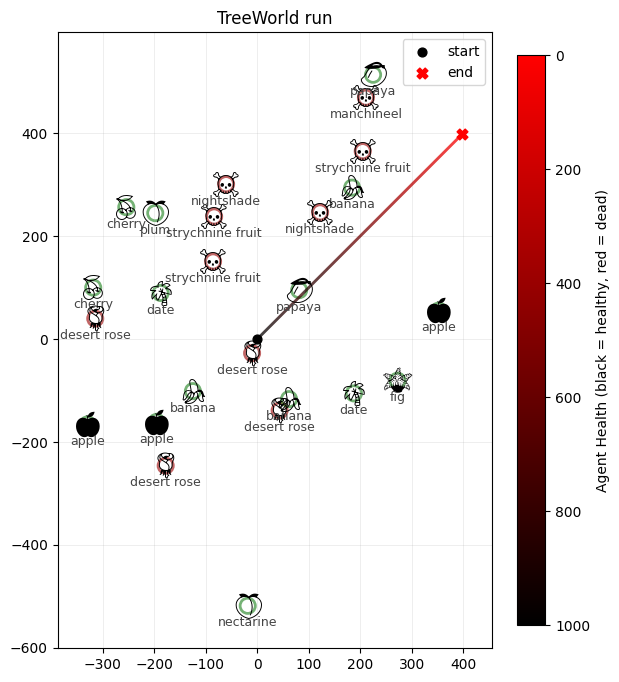

In [13]:
from tree_world.visualize import visualize_treeworld_run
visualize_treeworld_run(
    world.tree_locations.numpy().tolist(),
    [tree.name for tree in world.trees],
    [tree.is_poisonous for tree in world.trees],
    world.record_positions,
    world.record_healths,
    world.config.max_health,
    title="TreeWorld run",
    save_path="tree_world_run.png",
    show=False,
)